# Load Dataset

In [1]:
import common
import cv2
import os
import pandas as pd
import numpy as np
import mediapipe as mp
from scipy.spatial import distance

In [2]:
mpHands = mp.solutions.hands
hands = mpHands.Hands(max_num_hands=2)

dataset_path = 'hand_dataset'

y = []
X = []

for directory in os.listdir(dataset_path):
    sign_path = os.path.join(dataset_path, directory)
    
    for file in os.listdir(sign_path):
        file_path = os.path.join(sign_path, file)

        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        h, w, c = img.shape
        img = cv2.flip(img, 1)
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(imgRGB)

        hand_landmarks = common.get_right_hand_landmarks(results, h, w)

        if hand_landmarks is False:
            print(f'Landmarks not found in: {file_path}')

        if hand_landmarks is not False:
            y.append(directory)
            normalized_landmarks = common.normalize_hand_landmarks(hand_landmarks)
            df = pd.DataFrame(normalized_landmarks)
            df.columns = ['x', 'y', 'z']
            df.drop('z', axis=1, inplace=True)
            features = df.to_numpy().flatten()

            X.append(features)

y = np.asarray(y)
X = np.asarray(X)

Landmarks not found in: hand_dataset\e\IMG_20220314_151210.jpg
Landmarks not found in: hand_dataset\g\IMG_20220314_151330.jpg
Landmarks not found in: hand_dataset\i\IMG_20220314_151450.jpg
Landmarks not found in: hand_dataset\i\IMG_20220314_171228.jpg
Landmarks not found in: hand_dataset\m\IMG_20220314_151643.jpg
Landmarks not found in: hand_dataset\null\IMG_20220315_135215.jpg
Landmarks not found in: hand_dataset\null\IMG_20220315_135238.jpg
Landmarks not found in: hand_dataset\null\IMG_20220329_130201.jpg
Landmarks not found in: hand_dataset\x\IMG_20220314_152356.jpg
Landmarks not found in: hand_dataset\x\IMG_20220314_170832.jpg
Landmarks not found in: hand_dataset\x\IMG_20220314_171614.jpg
Landmarks not found in: hand_dataset\x\IMG_20220314_171621.jpg
Landmarks not found in: hand_dataset\z\IMG_20220314_152513.jpg
Landmarks not found in: hand_dataset\z\IMG_20220314_152522.jpg


# Model Cross Validation

In [5]:
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import time

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [6]:

#Parámetros para los modelos
seed = 9
degree = 3
num_trees = 27
kernel = 'poly'
max_iter = 200

# Se crean todos los modelos de machine learning
modelos = []
modelos.append(('LR', LogisticRegression(random_state=seed, max_iter=max_iter)))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier(random_state=seed)))
modelos.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
modelos.append(('NB', GaussianNB()))
modelos.append(('SVM', SVC(kernel=kernel, degree=degree)))

#Tabla para comparar modelos
tabla = pd.DataFrame()
tabla = pd.DataFrame(columns=['Modelo', 'Tiempo', 'Accuracy', 'Precision macro avg', 'Recall macro avg', 'f1-score macro avg', 
                        'semillas', 'grados', 'numero de arboles', 'kernel', 'iteraciones máximas'])

tabla = tabla.append(pd.Series([seed, degree, num_trees, kernel, max_iter], 
                            index=['semillas', 'grados', 'numero de arboles', 'kernel', 'iteraciones máximas']), 
                            ignore_index=True)

for nombre, modelo in modelos:
    #Validación para el caso mas extremo
    loo = LeaveOneOut()

    #se agregan variables para después usarlas para comparar las predicciones con lo que debería de ser
    predicted_targets = np.array([])
    real_targets = np.array([])
    
    #Inicia el cronometro para medir el tiempo de ejecución
    inicio = time.time()    

    #Al usar LeaveOneOut iterara, usando 99.9 de los datos y 0.01 para comparar
    #Ejemplo de 500 datos usara 499 para entrenar y 1 para testear, luego regresara esa que testeo a los datos 
    #sacara la siguiente continuamente hasta llegar a usar las 500, siempre usando 499 para entrenar y 1 para test
    for train_index, test_index in loo.split(X, y):
        #Recordemos que x tiene los datos y "y" tiene las etiquetas
        X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
        '''SVC
        # Se ajusta el clasificador
        clf = SVC(kernel='poly', degree=3).fit(X_train, y_train)

        # Se predecir las etiquetas de las muestras del conjunto de pruebas
        predicted_labels = clf.predict(X_test)

        # Se hace una lista de la etiqueta junto con el objetivo predicho
        predicted_targets = np.append(predicted_targets, predicted_labels)
        # Se hace una lista de la etiqueta real con el objetivo real para después comprobar resultados
        real_targets = np.append(real_targets, y_test)
        '''
        
        # Se ajusta(alimenta) el modelo
        clf = modelo.fit(X_train, y_train)

        # Se predicen las etiquetas de las muestras del conjunto de pruebas
        predicted_labels = clf.predict(X_test)

        # Se hace una lista de la etiqueta junto con el objetivo predicho
        predicted_targets = np.append(predicted_targets, predicted_labels)
        # Se hace una lista de la etiqueta real con el objetivo real para después comprobar resultados
        real_targets = np.append(real_targets, y_test)

    #Termina el cronometro para medir el tiempo de ejecución
    fin = time.time()

    #Se crea el reporte de clasificación
    reporte = classification_report(real_targets, predicted_targets, output_dict = True)

    #Se obtiene el parámetro de macro avg del reporte para agregarlo a la tabla
    macro_avg = reporte['macro avg']
    tabla = tabla.append(pd.Series([nombre, fin-inicio, reporte['accuracy'], macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score']], 
                            index=['Modelo', 'Tiempo', 'Accuracy', 'Precision macro avg', 'Recall macro avg', 'f1-score macro avg']), 
                            ignore_index=True)

#Imprime el reporte de clasificación 
print(tabla)
tabla.to_csv("fichero2.csv", encoding='latin1')

  Modelo      Tiempo  Accuracy Precision macro avg Recall macro avg  \
0    NaN         NaN       NaN                 NaN              NaN   
1     LR  103.174967  0.721354            0.729499         0.713786   
2    LDA    3.065037  0.856771            0.867296         0.856747   
3    KNN    0.626682  0.692708            0.724948         0.681239   
4   CART    8.494204  0.635417            0.627147         0.624598   
5     RF    44.53598  0.742188            0.754209         0.736847   
6     NB    2.096212  0.653646             0.67252         0.650778   
7    SVM    6.842545  0.854167            0.859025         0.851829   

  f1-score macro avg semillas grados numero de arboles kernel  \
0                NaN        9      3                27   poly   
1           0.716986      NaN    NaN               NaN    NaN   
2            0.85751      NaN    NaN               NaN    NaN   
3           0.683435      NaN    NaN               NaN    NaN   
4            0.62294      NaN    Na

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

0.8541666666666666 {'precision': 0.8590250756988498, 'recall': 0.8518285513769385, 'f1-score': 0.8512328415012557, 'support': 384}


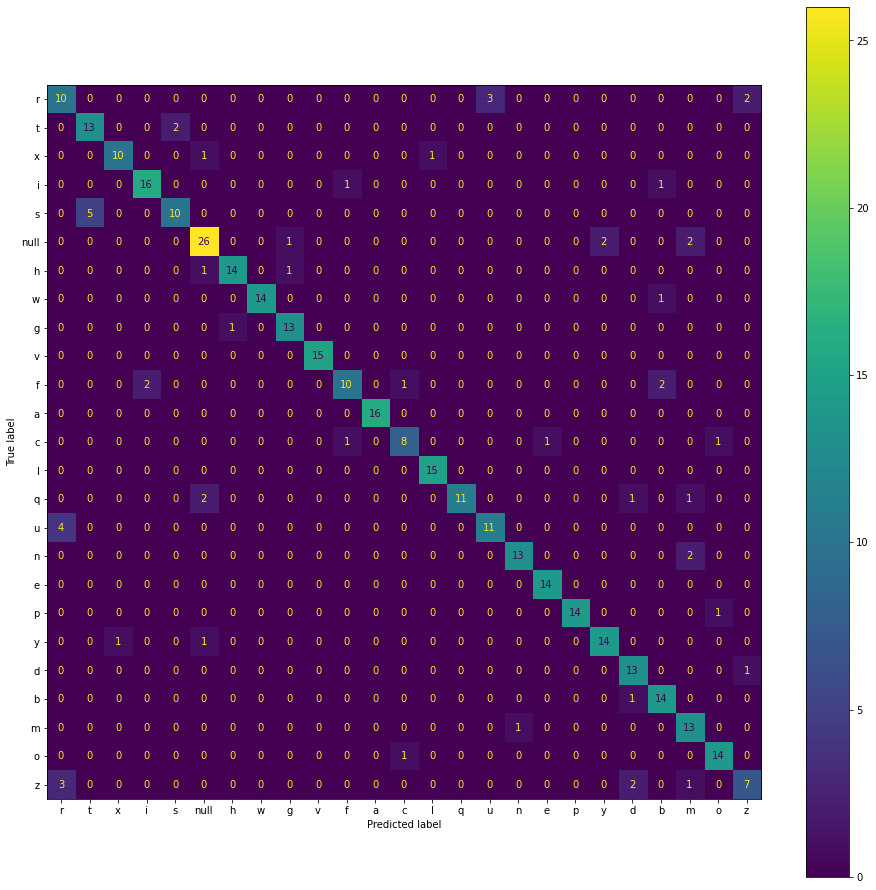

In [25]:
labels = list(set(y))
cm = confusion_matrix(real_targets, predicted_targets, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

#imprime la matriz de confusion
fig, ax = plt.subplots(figsize=(16,16))
disp.plot(ax=ax)

#Imprime el reporte de clasificación 
report = classification_report(real_targets, predicted_targets, output_dict = True)
print(report['accuracy'],report['macro avg'])


## Results

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

              precision    recall  f1-score   support

           a       1.00      1.00      1.00        16
           b       0.78      0.93      0.85        15
           c       0.80      0.73      0.76        11
           d       0.76      0.93      0.84        14
           e       0.93      1.00      0.97        14
           f       0.83      0.67      0.74        15
           g       0.87      0.93      0.90        14
           h       0.93      0.88      0.90        16
           i       0.89      0.89      0.89        18
           l       0.94      1.00      0.97        15
           m       0.68      0.93      0.79        14
           n       0.93      0.87      0.90        15
        null       0.84      0.84      0.84        31
           o       0.88      0.93      0.90        15
           p       1.00      0.93      0.97        15
           q       1.00      0.73      0.85        15
           r       0.59      0.67      0.62        15
           s       0.83    

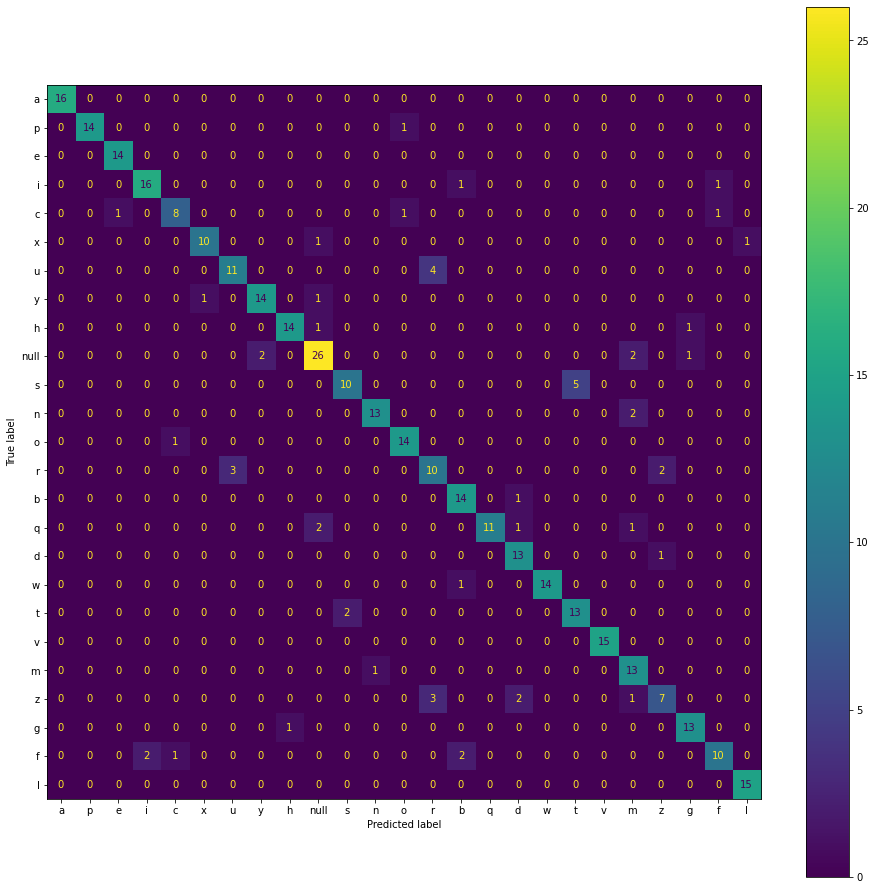

In [6]:
labels = list(set(y))
cm = confusion_matrix(actual_targets, predicted_targets, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(16,16))
disp.plot(ax=ax)
print(classification_report(actual_targets, predicted_targets))